In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("../input/netflix-stock-prediction/train.csv")
data.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


In [4]:
import matplotlib.pyplot as plt

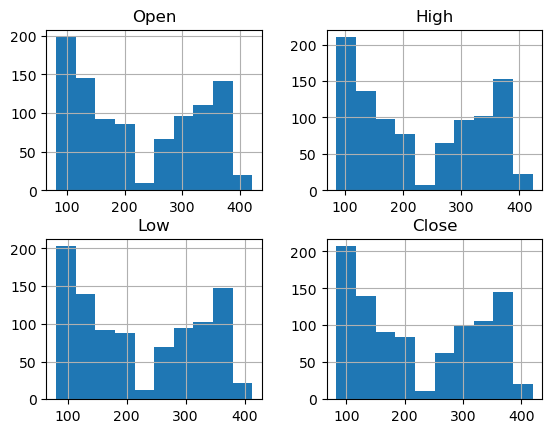

In [5]:
data_used = data.iloc[:, 1:4]
data_used["Close"] = data["Close"]
hist = data_used.hist()
plt.show()

# 학습용 데이터 만들기

In [6]:
from torch.utils.data.dataset import Dataset

In [7]:
class Netflix(Dataset):
    def __init__(self):
        self.csv = pd.read_csv("../input/netflix-stock-prediction/train.csv")

        self.data = self.csv.iloc[:, 1:4].values
        self.data = self.data / np.max(self.data)

        self.label = data["Close"].values
        self.label = self.label / np.max(self.label)

    def __len__(self):
        # 사용 가능한 배치 개수
        return len(self.data) - 30

    def __getitem__(self, i):
        data = self.data[i : i + 30]
        label = self.label[i + 30]

        return data, label

# RNN 모델 정의하기

In [8]:
import torch
import torch.nn as nn

In [9]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()

        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)

        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x, h0):
        # 마지막 RNN 층의 은닉 상태, 모든 RNN 층의 은닉 상태
        x, hn = self.rnn(x, h0)

        x = torch.reshape(x, (x.shape[0], -1))

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        x = torch.flatten(x)

        return x

# 모델 학습하기

In [10]:
import tqdm
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
model = RNN().to(device)

In [13]:
dataset = Netflix()
loader = DataLoader(dataset, batch_size=32)

In [14]:
optim = Adam(params=model.parameters(), lr=0.0001)

In [16]:
for epoch in range(200):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()

        h0 = torch.zeros(5, data.shape[0], 8).to(device)

        pred = model(data.type(torch.FloatTensor).to(device), h0)

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))

        loss.backward()
        optim.step()

        iterator.set_description(f"epoch: {epoch} loss: {loss.item()}")

epoch: 199 loss: 0.0016466176602989435: 100%|█████████████████████████████████████████| 30/30 [00:00<00:00, 167.13it/s]


In [17]:
torch.save(model.state_dict(), "./rnn.pth")

# 모델 성능 평가하기

In [18]:
loader = DataLoader(dataset, batch_size=1)

In [19]:
preds = []
total_loss = 0

with torch.no_grad():
    model.load_state_dict(torch.load("rnn.pth", weights_only=True, map_location=device))

    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(device)

        pred = model(data.type(torch.FloatTensor).to(device), h0)
        preds.append(pred.item())

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(device))

        total_loss += loss / len(loader)

total_loss.item()

0.0027605840004980564

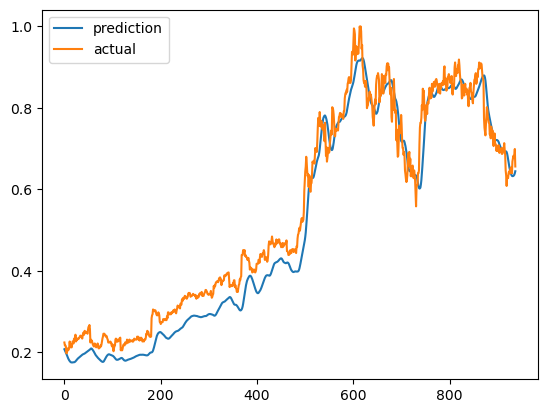

In [20]:
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()